# Basic Gates

Basic quantum gates.

The bloqs in this module encode gates you'd expect to find in any quantum computing
framework. It includes single-qubit unitary gates like rotations, bit- and phase-flip;
basic multi-qubit unitary gates; states and effects in the Pauli basis; and non-Clifford
gates `TGate` and `Toffoli` which are commonly counted to estimate algorithm resource
requirements.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `CNOT`
Two-qubit controlled-NOT.

#### Registers
 - `ctrl`: One-bit control register.
 - `target`: One-bit target register.


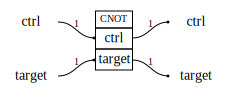

In [2]:
from qualtran.bloqs.basic_gates import CNOT

bloq = CNOT()
show_bloq(bloq)

We show how CNOT is represented as a facorized tensor during Quimb tensor simulation.

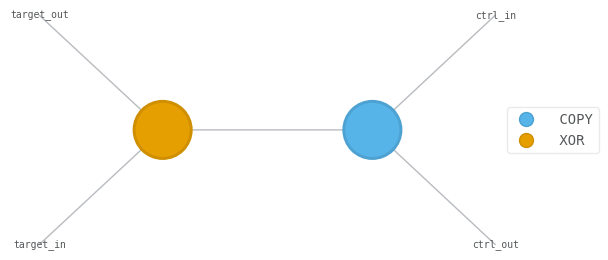

In [3]:
from qualtran.simulation.tensor import (
    cbloq_to_quimb, get_right_and_left_inds
)

cbloq = bloq.as_composite_bloq()
tn, _ = cbloq_to_quimb(cbloq)

# Rename the indices to something less verbose
from qualtran._infra.composite_bloq import _get_dangling_soquets
lsoqs = _get_dangling_soquets(cbloq.signature, right=False)
rsoqs = _get_dangling_soquets(cbloq.signature, right=True)

# Note: the following only works for single-dimension soquets.
rename = {lsoqs[k]: f'{k}_in' for k in lsoqs.keys()}
rename |= {rsoqs[k]: f'{k}_out' for k in rsoqs.keys()}
tn = tn.reindex(rename)

tn.draw(color=['COPY', 'XOR'], show_tags=False, initial_layout='spectral')

In [4]:
bloq.tensor_contract()

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

## `PlusState`
The state |+>

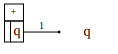

In [5]:
from qualtran.bloqs.basic_gates import PlusState

bloq = PlusState()
show_bloq(bloq)

In [6]:
bloq.tensor_contract()

array([0.70710678+0.j, 0.70710678+0.j])

## `ZeroState`
The state |0>

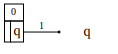

In [7]:
from qualtran.bloqs.basic_gates import ZeroState

bloq = ZeroState()
show_bloq(bloq)

## Synthesizing a Bell state

We can create a bell state (|00> + |11>) by cnotting a |+> state into a |0> state.

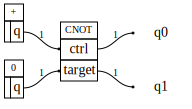

In [8]:
from qualtran.bloqs.basic_gates import ZeroState

bb = BloqBuilder()

q0 = bb.add(PlusState())
q1 = bb.add(ZeroState())

q0, q1 = bb.add(CNOT(), ctrl=q0, target=q1)

cbloq = bb.finalize(q0=q0, q1=q1)
show_bloq(cbloq)

In [9]:
cbloq.tensor_contract()

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

We can see how this composite bloq corresponds to a quimb tensor network.

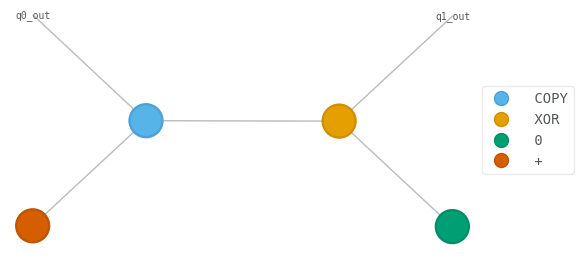

In [10]:
tn, _ = cbloq_to_quimb(cbloq)
lsoqs = _get_dangling_soquets(cbloq.signature, right=False)
rsoqs = _get_dangling_soquets(cbloq.signature, right=True)

# Note: the following only works for single-dimension soquets.
rename = {lsoqs[k]: f'{k}_in' for k in lsoqs.keys()}
rename |= {rsoqs[k]: f'{k}_out' for k in rsoqs.keys()}
tn = tn.reindex(rename)

tn.draw(color=['COPY', 'XOR', '0', '+'], show_tags=False, initial_layout='spectral')

`PlusState` and `ZeroState` provide `as_cirq_op` methods for Cirq interoperability, resulting in the familiar `cirq.Circuit` for constructing a Bell state.

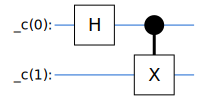

In [11]:
from cirq.contrib.svg import SVGCircuit
circuit, qubits = cbloq.to_cirq_circuit()
SVGCircuit(circuit)

## `Rz`
Single-qubit Rz gate.

#### Parameters
 - `angle`: Rotation angle in radians.
 - `eps`: precision for implementation of rotation. 

#### Registers
 - `q`: One-bit register. 

#### References
[Efficient synthesis of universal Repeat-Until-Success
circuits](https://arxiv.org/abs/1404.5320), which offers a small improvement
[Optimal ancilla-free Clifford+T approximation
of z-rotations](https://arxiv.org/pdf/1403.2975.pdf).


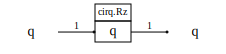

In [12]:
from qualtran.bloqs.basic_gates import Rz

bloq = Rz(angle=np.pi / 4.0)
show_bloq(bloq)

## `TGate`
The T gate.

This is the fourth root of the Pauli Z gate. Quantum programs composed solely
of gates belonging to the Clifford group (like X, Z, Hadamard, CNOT, S) can be simulated
efficiently by a classical computer and therefore offer no quantum advantage. The Clifford
gates do not provide a universal quantum gateset. The addition of any non-Clifford gate
makes the gateset universal. One of the most popular additions is the T gate, yielding
the common Clifford+T gateset.

The unitary matrix of `cirq.T` is
$$
\begin{bmatrix}
    1 & 0 \\
    0 & e^{i \pi /4}
\end{bmatrix}
$$

#### Parameters
 - `is_adjoint`: If True, this bloq is $T^\dagger$ instead. 

#### Registers
 - `q`: The qubit 

#### References
[Universal Quantum Computation with ideal Clifford gates and noisy ancillas](https://arxiv.org/abs/quant-ph/0403025).
    Bravyi and Kitaev. 2004.
[Fast and efficient exact synthesis of single qubit unitaries generated by Clifford and T gates](https://arxiv.org/abs/1206.5236).
    Kliuchnikov et. al. 2012.
[Universal Gate Set, Magic States, and costliness of the T gate](https://quantumcomputing.stackexchange.com/a/33358).
    Gidney. 2023.


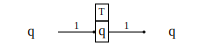

In [13]:
from qualtran.bloqs.basic_gates import TGate

bloq = TGate()
show_bloq(bloq)

We can create the "magic state" T|+> which is used via teleportation to do non-Clifford operations in the surface code.

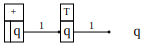

In [14]:
bb = BloqBuilder()
q = bb.add(PlusState())
q = bb.add(TGate(), q=q)
cbloq = bb.finalize(q=q)
show_bloq(cbloq)

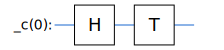

In [15]:
circuit, _ = cbloq.to_cirq_circuit()
SVGCircuit(circuit)

In [16]:
psi = circuit.final_state_vector()
psi * np.sqrt(2)

array([1.        +0.j        , 0.70710678+0.70710678j])

## `Toffoli`
The Toffoli gate.

This will flip the target bit if both controls are active. It can be thought of as
a reversible AND gate.

Like `TGate`, this is a common compilation target. The Clifford+Toffoli gateset is
universal.

#### References
[Novel constructions for the fault-tolerant Toffoli gate](https://arxiv.org/abs/1212.5069).
Cody Jones. 2012. Provides a decomposition into 4 `TGate`.


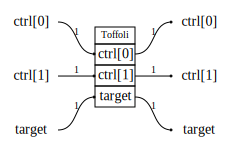

In [17]:
from qualtran.bloqs.basic_gates import Toffoli

bloq = Toffoli()
show_bloq(bloq)

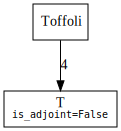

#### Counts totals:
 - `TGate()`: 4

In [18]:
from qualtran.drawing import show_call_graph, show_counts_sigma

g, sigma = bloq.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)

## `Hadamard`
The Hadamard gate

This converts between the X and Z basis.

$$
H |0\rangle = |+\rangle \\
H |-\rangle = |1\rangle
$$

#### Registers
 - `q`: The qubit


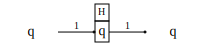

In [19]:
from qualtran.bloqs.basic_gates import Hadamard

bloq = Hadamard()
show_bloq(bloq)